In [1]:
import torch
from nnsight import LanguageModel
from datasets import load_from_disk
from data import create_prompt
from tqdm.notebook import tqdm

from transformers import AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

In [5]:
# model_path = 'microsoft/phi-2'
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForCausalLM.from_pretrained(model_path)
# if tokenizer.pad_token is None:
#     tokenizer.pad_token = tokenizer.eos_token

/home/tunghoang/anaconda3/envs/interpreting/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
ds = load_from_disk("datasets/value_at_index/v0.0")
ds = ds.filter(lambda e: (e['query_array_length'] == 5) and (e['num_few_shots'] == 0) and (e['query'] == 3))
ds = ds.map(create_prompt)

In [ ]:
# tokenized_ds = ds.map(lambda x: tokenizer(x, return_tensors='pt', padding=True), batched=True)
# dl = DataLoader(ds, collate_fn=lambda x: tokenizer(x, return_tensors='pt', padding=True))

## Interventing

In [3]:
model = LanguageModel('microsoft/phi-2', device_map='auto')
tokenizer = model.tokenizer
# model = LanguageModel('openai-community/gpt2', device_map='auto')
model

/home/tunghoang/anaconda3/envs/interpreting/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

In [5]:
model.tokenizer.padding_side = 'left'
if model.tokenizer.pad_token is None:
    model.tokenizer.pad_token = model.tokenizer.eos_token

In [4]:
prompt = ds[2]['prompt']
print(prompt)
ids = model.tokenizer.encode(prompt)
print(len(ids))
print(model.tokenizer.decode(ids[:12]))
print(model.tokenizer.decode(ids[12:]))

Output the value of an array at a given index.
a=[9, 7, 1, 9, 6]. a[3]=
28
Output the value of an array at a given index.

a=[9, 7, 1, 9, 6]. a[3]=


In [6]:
X = model.tokenizer(ds['prompt'])
tokenized_data = ds.map(lambda example: model.tokenizer(example["prompt"], truncation=True))
tokenized_data = tokenized_data.remove_columns(['array', 'query', 'target', 'few_shots', 'query_array_length', 'num_few_shots', 'task_prompt', 'prompt',])

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=model.tokenizer)
dl = DataLoader(tokenized_data, batch_size=32, shuffle=False, collate_fn=data_collator)

with torch.no_grad():
    all_preds = []
    for sample in tqdm(dl):
        # prompt = sample['prompt']
        corrupted_preds = []
        # with model.generate(prompt, max_new_tokens=1):
        #     orig_output = model.generator.output.save()
        # orig_output = orig_output[0][-1].item()
        for i in range(12, 28):
            with model.generate(sample, max_new_tokens=1):
                # emb = model.transformer.wte.output.save()
                # noise = torch.randn([1, emb.shape[-1]])
                # emb[:, i, :] += noise
                # model.transformer.wte.output = emb
                # output = model.generator.output.save()
                emb = model.model.embed_tokens.output.save()
                noise = torch.randn([emb.shape[0], emb.shape[-1]], device=emb.device, dtype=emb.dtype)
                emb[:, i, :] += noise
                model.model.embed_tokens.output = emb
                output = model.generator.output.save()
            corrupted_preds.append(output[0][-1].item())
        # orig_preds, *corrupted_preds = model.tokenizer.batch_decode([orig_output] + corrupted_preds)
        all_preds.append(corrupted_preds)
            # print(model.tokenizer.decode(output[0]))
# torch.save(all_preds, "corrupted_l5_s0_i3_gpt2.pkl")

  0%|          | 0/6 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 fo

In [19]:
is_correct = []
for i, s in enumerate(all_preds):
    s = model.tokenizer.batch_decode(s)
    is_correct.append([t == str(ds[i]['target']) for t in s])

In [25]:
important = is_correct.sum(dim=0) / is_correct.shape[0]

In [31]:
list(zip(important, model.tokenizer.batch_decode(ids[12:28])))

[(tensor(0.1667), 'a'),
 (tensor(0.), '=['),
 (tensor(0.1667), '9'),
 (tensor(0.1667), ','),
 (tensor(0.1667), ' 7'),
 (tensor(0.1667), ','),
 (tensor(0.1667), ' 1'),
 (tensor(0.), ','),
 (tensor(0.), ' 9'),
 (tensor(0.1667), ','),
 (tensor(0.1667), ' 6'),
 (tensor(0.), '].'),
 (tensor(0.1667), ' a'),
 (tensor(0.1667), '['),
 (tensor(0.1667), '3'),
 (tensor(0.), ']=')]

In [27]:
import matplotlib.pyplot as plt
import numpy as np

In [28]:
x = model.tokenizer.batch_decode(ids[13:28])
y = important.tolist()
print(list(zip(x,y)))

[('=[', 0.1666666716337204), ('9', 0.0), (',', 0.1666666716337204), (' 7', 0.1666666716337204), (',', 0.1666666716337204), (' 1', 0.1666666716337204), (',', 0.1666666716337204), (' 9', 0.0), (',', 0.0), (' 6', 0.1666666716337204), ('].', 0.1666666716337204), (' a', 0.0), ('[', 0.1666666716337204), ('3', 0.1666666716337204), (']=', 0.1666666716337204)]


In [29]:
x[1] = 'x0'
x[3] = ' x1'
x[5] = ' x2'
x[7] = ' x3'
x[9] = ' x4'
x

['=[',
 'x0',
 ',',
 ' x1',
 ',',
 ' x2',
 ',',
 ' x3',
 ',',
 ' x4',
 '].',
 ' a',
 '[',
 '3',
 ']=']

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (15,) and arg 1 with shape (16,).

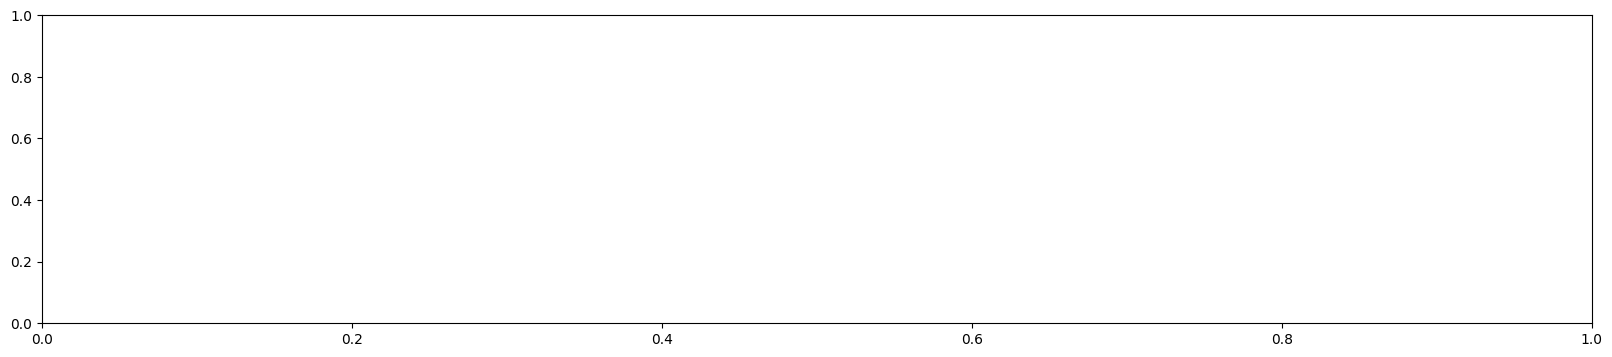

In [30]:
fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(np.arange(len(x)), y, tick_label=x)